In [1]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *
from tqdm import tqdm
from matplotlib.dates import DateFormatter

## T4.3: Validate Ensemble forecast using Glider Data

An **ensemble of 10 members** has been run by **CMCC (UNIBO)**. **Gliders from SOCIB** in the Western Mediterranean are used to validate de ensemble.

Model has a regular grid and a horizontal resolution of 1/16

Theoretically, the glider profile should lie within the ensmeble spread. I.e., the posibilities that the ensmeble represent should be fit to represent the real observations.

In [2]:
files_temp = glob("/LOCALDATA/Data/EuroSea_WP4_T4.3/exp_20210601_*_T.nc")
print(F"n = {len(files_temp)} ensmeble member Temperature files found")

ds_temp = xr.open_dataset(files_temp[0])

n = 12 ensmeble member Temperature files found


#### Get Glider Data

In [3]:
# Glider file path
file_glider = 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2021/dep0004_sdeep06_scb-sldeep006_L2_2021-05-17_data_dt.nc'
# Load glider DataSet
ds_glider_all = xr.open_dataset(file_glider)

# Subset to correspond with Model time
ds_glider = ds_glider_all.sel(time=slice(ds_temp.time_counter.min().values,ds_temp.time_counter.max().values))
#ds_glider = ds_glider_all.sel(time=slice('2021-06-01','2021-06-10'))

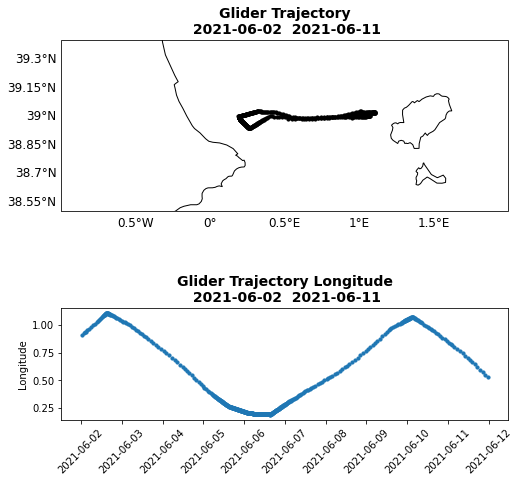

In [4]:

fig_glider = plt.figure(figsize=(8,7))
ax, gl = tools.make_map(limits=[-1,2,38.5,39.4], subplot_dim=(2,1,1))

plt.scatter(ds_glider.longitude, ds_glider.latitude, 10, 'k', transform=gl.crs)
plt.title(F'Glider Trajectory\n 2021-06-02  2021-06-11', fontsize=14, fontweight='bold')
# plt.show()

# plt.figure()
plt.subplot(3,1,3)
plt.scatter(ds_glider.time.values, ds_glider.longitude.values, 10)
plt.xticks(rotation=45)
plt.title(F'Glider Trajectory Longitude\n 2021-06-02  2021-06-11', fontsize=14, fontweight='bold')
plt.ylabel('Longitude')
plt.show()

In [5]:
fig_glider.savefig(F"/home/jhernandez/Escritorio/WP4_T4.3/glider_trajectory_20210602-20210611.png",
                 dpi=250, transparent=False, facecolor="w")

### Interpolate Model to Glider Obs (In time, Lon, Lat)

Get closest grid point and interpolate in time. Keep Model depths

##### Ensemble temperature files

In [6]:
#  Model lat and lon
lat_model = ds_temp.nav_lat[:,0].values
lon_model = ds_temp.nav_lon[0,:].values

# Element of the lon and lat correspondant to Profile
nlat = [np.argmin(np.abs(l - lat_model)) for l in ds_glider.latitude.values]
nlon = [np.argmin(np.abs(l - lon_model)) for l in ds_glider.longitude.values]

### Get Ensemble members equivalents of glider observations

In [7]:
files_temp = glob("/LOCALDATA/Data/EuroSea_WP4_T4.3/exp_20210601_*_T.nc")
files_temp.sort()
files_salt = glob("/LOCALDATA/Data/EuroSea_WP4_T4.3/exp_20210601_*_S.nc")
files_salt.sort()
print(F"n = {len(files_temp)} ensmeble member Temperature files found")
print(F"n = {len(files_salt)} ensmeble member Salinty files found")

# Create empty matrix Temperature
Temp_ensemble_interp = np.empty((len(files_temp), ds_temp.deptht.shape[0], ds_glider.time.shape[0]))
Temp_glider_interp = np.empty((ds_temp.deptht.shape[0], ds_glider.time.shape[0]))

# Create empty matrix Salinity
Salt_ensemble_interp = np.empty((len(files_salt), ds_temp.deptht.shape[0], ds_glider.time.shape[0]))
Salt_glider_interp = np.empty((ds_temp.deptht.shape[0], ds_glider.time.shape[0]))

for n in tqdm(range(len(files_temp))):
    
    ds_temp = xr.open_dataset(files_temp[n])
    ds_salt = xr.open_dataset(files_salt[n])
    
    for i in range(ds_glider.time.shape[0]):

        # Interpolate (in time and depth) model to Argo observations
        Temp_ensemble_interp[n,:,i] = ds_temp.votemper[:,:,nlat[i], nlon[i]].interp(time_counter=ds_glider.time[i])#, deptht=ds_glider.depth)
        Salt_ensemble_interp[n,:,i] = ds_salt.vosaline[:,:,nlat[i], nlon[i]].interp(time_counter=ds_glider.time[i])#, deptht=ds_glider.depth)
        
        if n==0:
            Temp_glider_interp[:,i] = np.interp(ds_temp.deptht.values, ds_glider.depth.values, ds_glider.temperature[i,:])
            Salt_glider_interp[:,i] = np.interp(ds_salt.deptht.values, ds_glider.depth.values, ds_glider.salinity[i,:])
    
Temp_ensemble_interp[Temp_ensemble_interp==0] = np.nan
Salt_ensemble_interp[Salt_ensemble_interp==0] = np.nan

  0%|          | 0/12 [00:00<?, ?it/s]

n = 12 ensmeble member Temperature files found
n = 12 ensmeble member Salinty files found


100%|██████████| 12/12 [06:13<00:00, 31.12s/it]


In [9]:
Temp_spread = np.max(Temp_ensemble_interp,axis=0) - np.min(Temp_ensemble_interp,axis=0)
Salt_spread = np.max(Salt_ensemble_interp,axis=0) - np.min(Salt_ensemble_interp,axis=0)


In [10]:
misfit_temp = np.empty_like((Temp_ensemble_interp))
misfit_salt = np.empty_like((Salt_ensemble_interp))
for i in range(Temp_ensemble_interp.shape[0]):
    misfit_temp[i,:,:] = Temp_ensemble_interp[i,:,:] - Temp_glider_interp
    misfit_salt[i,:,:] = Salt_ensemble_interp[i,:,:] - Salt_glider_interp

### Plot

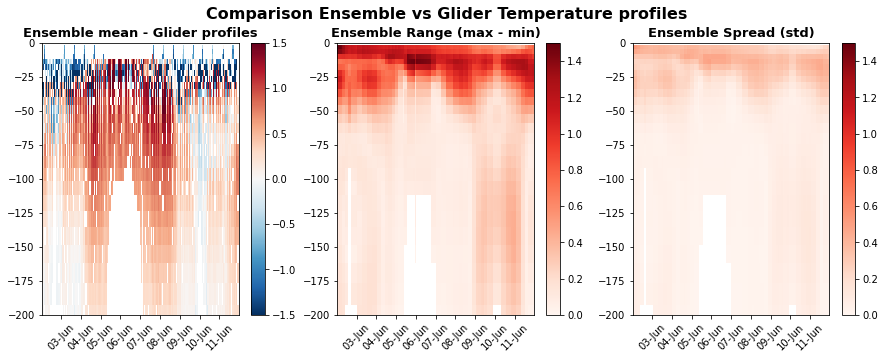

In [11]:
fig_temp = plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,3,1)
plt.pcolormesh(ds_glider.time.values, -ds_temp.deptht.values, Temp_ensemble_interp.mean(axis=0) - Temp_glider_interp,
               cmap='RdBu_r', vmin=-1.5, vmax=1.5)
               # cmap='Reds', vmin=0, vmax=1.5)
plt.colorbar()
plt.title('Ensemble mean - Glider profiles', fontsize=13, fontweight='bold')
plt.ylim(-200,0)
plt.xticks(rotation=45)
date_form = DateFormatter("%d-%b")
ax1.xaxis.set_major_formatter(date_form)

ax2 = plt.subplot(1,3,2)
plt.pcolormesh(ds_glider.time.values, -ds_temp.deptht.values, Temp_spread, cmap='Reds', vmin=0, vmax=1.5)
plt.colorbar()
plt.title('Ensemble Range (max - min)', fontsize=13, fontweight='bold')
plt.ylim(-200,0)
plt.xticks(rotation=45)
ax2.xaxis.set_major_formatter(date_form)

ax3 = plt.subplot(1,3,3)
plt.pcolormesh(ds_glider.time.values, -ds_temp.deptht.values, Temp_ensemble_interp.std(axis=0), cmap='Reds', vmin=0, vmax=1.5)
plt.colorbar()
plt.title('Ensemble Spread (std)', fontsize=13, fontweight='bold')
plt.ylim(-200,0)
plt.xticks(rotation=45)
ax3.xaxis.set_major_formatter(date_form)

plt.suptitle('Comparison Ensemble vs Glider Temperature profiles', fontsize=16, fontweight='bold')
plt.show()

In [31]:
fig_temp.savefig("/home/jhernandez/Escritorio/WP4_T4.3/Glider-vs-ensemble_temperature_profiles.png",
                 dpi=250, transparent=False, facecolor="w")

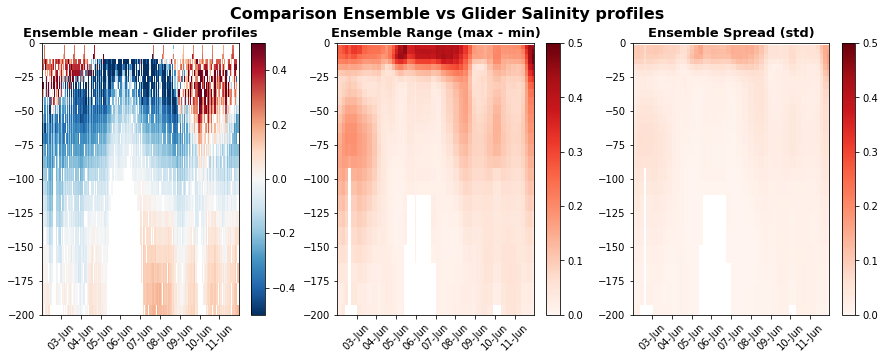

In [12]:
fig_salt = plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,3,1)
plt.pcolormesh(ds_glider.time.values, -ds_salt.deptht.values, Salt_ensemble_interp.mean(axis=0) - Salt_glider_interp,
               cmap='RdBu_r', vmin=-0.5, vmax=0.5)
               # cmap='Reds', vmin=0, vmax=1.5)
plt.colorbar()
plt.title('Ensemble mean - Glider profiles', fontsize=13, fontweight='bold')
plt.ylim(-200,0)
plt.xticks(rotation=45)
date_form = DateFormatter("%d-%b")
ax1.xaxis.set_major_formatter(date_form)

ax2 = plt.subplot(1,3,2)
plt.pcolormesh(ds_glider.time.values, -ds_salt.deptht.values, Salt_spread, cmap='Reds', vmin=0, vmax=0.5)
plt.colorbar()
plt.title('Ensemble Range (max - min)', fontsize=13, fontweight='bold')
plt.ylim(-200,0)
plt.xticks(rotation=45)
ax2.xaxis.set_major_formatter(date_form)

ax3 = plt.subplot(1,3,3)
plt.pcolormesh(ds_glider.time.values, -ds_salt.deptht.values, Salt_ensemble_interp.std(axis=0), cmap='Reds', vmin=0, vmax=0.5)
plt.colorbar()
plt.title('Ensemble Spread (std)', fontsize=13, fontweight='bold')
plt.ylim(-200,0)
plt.xticks(rotation=45)
ax3.xaxis.set_major_formatter(date_form)

plt.suptitle('Comparison Ensemble vs Glider Salinity profiles', fontsize=16, fontweight='bold')
plt.show()

In [29]:
fig_salt.savefig("/home/jhernandez/Escritorio/WP4_T4.3/Glider-vs-ensemble_salinity_profiles.png",
                 dpi=250, transparent=False, facecolor="w")

### Plot Profile of Ensmeble Spread and Glider mean Misfit with Ensemble members 

In [36]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


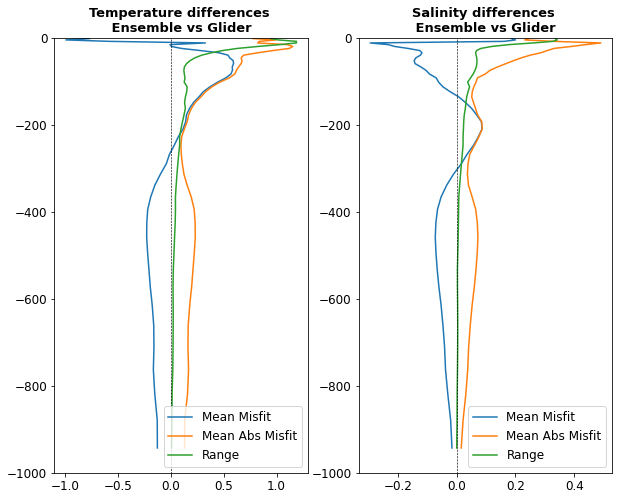

In [32]:
fig_prof = plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(np.nanmean( (Temp_ensemble_interp.mean(axis=0) - Temp_glider_interp), axis=1 ), -ds_temp.deptht.values, label='Mean Misfit' )
#plt.plot(np.nanmean( Temp_ensemble_interp.std(axis=0), axis=1 ), -ds_temp.deptht.values, label='Std Ensemble' )
plt.plot(np.nanmean( np.abs(Temp_ensemble_interp.mean(axis=0) - Temp_glider_interp), axis=1 ), -ds_temp.deptht.values, label='Mean Abs Misfit' )
plt.plot(np.nanmean(Temp_spread, axis=1), -ds_temp.deptht.values, label='Range')
plt.legend()

plt.plot(-ds_temp.deptht.values*0, -ds_temp.deptht.values, 'k--', linewidth=0.6)
plt.title('Temperature differences \n Ensemble vs Glider ', fontsize=13, fontweight='bold')
plt.ylim((-1000,0))

plt.subplot(1,2,2)
plt.plot(np.nanmean( (Salt_ensemble_interp.mean(axis=0) - Salt_glider_interp), axis=1 ), -ds_salt.deptht.values, label='Mean Misfit' )
plt.plot(np.nanmean( np.abs(Salt_ensemble_interp.mean(axis=0) - Salt_glider_interp), axis=1 ), -ds_salt.deptht.values, label='Mean Abs Misfit' )
plt.plot(np.nanmean(Salt_spread, axis=1), -ds_salt.deptht.values, label='Range')
plt.legend()

plt.plot(-ds_salt.deptht.values*0, -ds_salt.deptht.values, 'k--', linewidth=0.6)
plt.title('Salinity differences \n Ensemble vs Glider ', fontsize=13, fontweight='bold')
plt.ylim((-1000,0))

plt.show()

In [33]:
fig_prof.savefig("/home/jhernandez/Escritorio/WP4_T4.3/Glider-vs-ensemble_mean_profiles.png",
                 dpi=250, transparent=False, facecolor="w")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


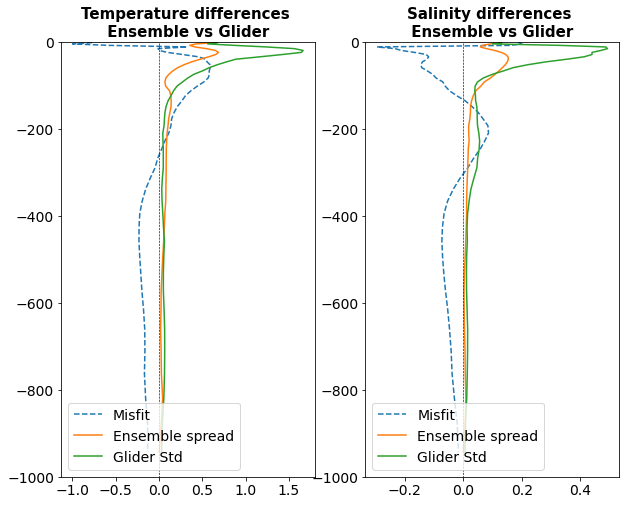

In [37]:
fig_prof = plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot( np.nanmean( np.nanmean( misfit_temp, axis=0 ), axis=1) , -ds_temp.deptht.values, '--', label='Misfit' )
plt.plot(np.nanstd( np.nanmean(Temp_ensemble_interp, axis=0), axis=1), -ds_temp.deptht.values, label='Ensemble spread')
# plt.plot(np.nanmean(Temp_spread, axis=1), -ds_temp.deptht.values, label='Range')
plt.plot(np.nanstd(Temp_glider_interp, axis=1), -ds_temp.deptht.values, label='Glider Std')
plt.legend()

plt.plot(-ds_temp.deptht.values*0, -ds_temp.deptht.values, 'k--', linewidth=0.6)
plt.title('Temperature differences \n Ensemble vs Glider ', fontsize=15, fontweight='bold')
plt.ylim((-1000,0))

plt.subplot(1,2,2)
plt.plot( np.nanmean( np.nanmean( misfit_salt, axis=0 ), axis=1 ), -ds_salt.deptht.values, '--' , label='Misfit')
plt.plot(np.nanstd( np.nanmean(Salt_ensemble_interp, axis=0), axis=1), -ds_salt.deptht.values, label='Ensemble spread')#, c='firebrick')
#plt.plot(np.nanmean(Salt_spread, axis=1), -ds_salt.deptht.values, label='Range')
plt.plot(np.nanstd(Salt_glider_interp, axis=1), -ds_salt.deptht.values, label='Glider Std')#, c='red')
plt.legend()

plt.plot(-ds_salt.deptht.values*0, -ds_salt.deptht.values, 'k--', linewidth=0.6)
plt.title('Salinity differences \n Ensemble vs Glider ', fontsize=15, fontweight='bold')
plt.ylim((-1000,0))

plt.show()

In [38]:
fig_prof.savefig("/home/jhernandez/Escritorio/WP4_T4.3/Glider-vs-ensemble_mean_profiles_absolute.png",
                 dpi=250, transparent=False, facecolor="w")

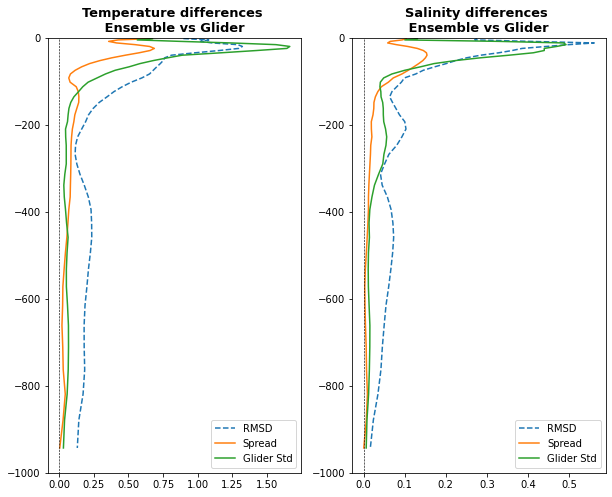

In [14]:
fig_prof = plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot( np.sqrt( np.nanmean( np.nanmean( misfit_temp**2, axis=0 ), axis=1) ), -ds_temp.deptht.values, '--', label='RMSD' )
plt.plot(np.nanstd( np.nanmean(Temp_ensemble_interp, axis=0), axis=1), -ds_temp.deptht.values, label='Spread')
# plt.plot(np.nanmean(Temp_spread, axis=1), -ds_temp.deptht.values, label='Range')
plt.plot(np.nanstd(Temp_glider_interp, axis=1), -ds_temp.deptht.values, label='Glider Std')
plt.legend()

plt.plot(-ds_temp.deptht.values*0, -ds_temp.deptht.values, 'k--', linewidth=0.6)
plt.title('Temperature differences \n Ensemble vs Glider ', fontsize=13, fontweight='bold')
plt.ylim((-1000,0))

plt.subplot(1,2,2)
plt.plot( np.sqrt( np.nanmean( np.nanmean( misfit_salt**2, axis=0 ), axis=1) ), -ds_salt.deptht.values, '--' , label='RMSD')
plt.plot(np.nanstd( np.nanmean(Salt_ensemble_interp, axis=0), axis=1), -ds_salt.deptht.values, label='Spread')#, c='firebrick')
#plt.plot(np.nanmean(Salt_spread, axis=1), -ds_salt.deptht.values, label='Range')
plt.plot(np.nanstd(Salt_glider_interp, axis=1), -ds_salt.deptht.values, label='Glider Std')#, c='red')
plt.legend()

plt.plot(-ds_salt.deptht.values*0, -ds_salt.deptht.values, 'k--', linewidth=0.6)
plt.title('Salinity differences \n Ensemble vs Glider ', fontsize=13, fontweight='bold')
plt.ylim((-1000,0))

plt.show()

In [575]:
fig_prof.savefig("/home/jhernandez/Escritorio/WP4_T4.3/Glider-vs-ensemble_mean_profiles_v2.png",
                 dpi=250, transparent=False, facecolor="w")

## Check horizontal spread

 17%|█▋        | 2/12 [00:00<00:00, 17.93it/s]

n = 12 ensmeble member Temperature files found
n = 12 ensmeble member Salinty files found


100%|██████████| 12/12 [00:00<00:00, 19.58it/s]


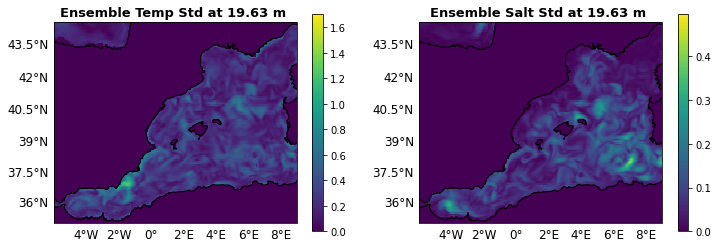

100%|██████████| 12/12 [00:00<00:00, 23.09it/s]


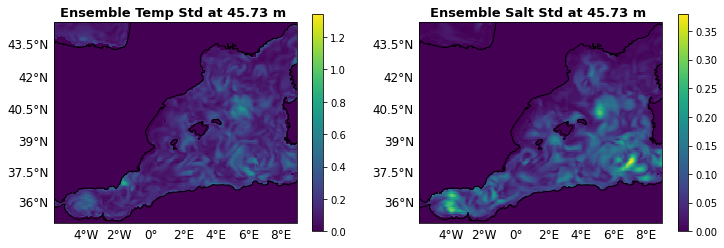

100%|██████████| 12/12 [00:00<00:00, 18.40it/s]


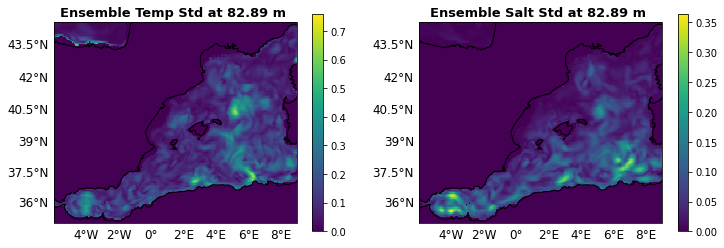

100%|██████████| 12/12 [00:00<00:00, 21.62it/s]


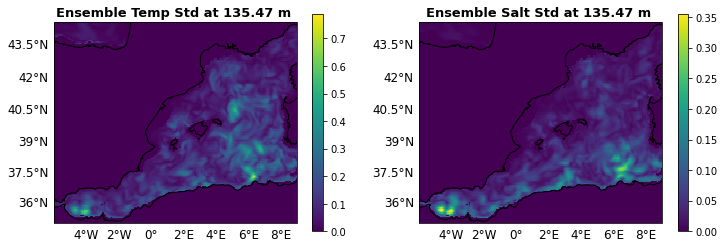

100%|██████████| 12/12 [00:00<00:00, 21.42it/s]


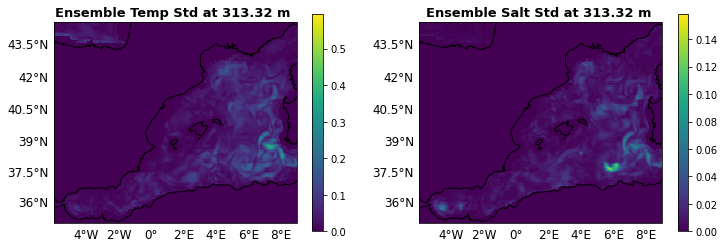

100%|██████████| 12/12 [00:00<00:00, 20.83it/s]


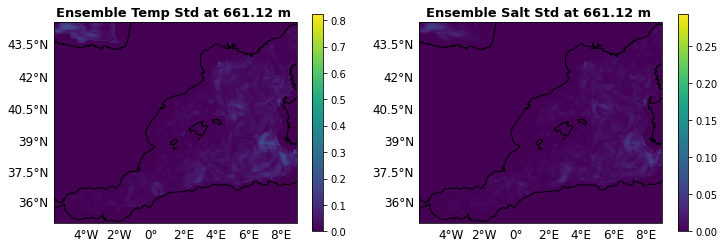

In [9]:
files_temp = glob("/LOCALDATA/Data/EuroSea_WP4_T4.3/exp_20210601_*_T.nc")
files_salt = glob("/LOCALDATA/Data/EuroSea_WP4_T4.3/exp_20210601_*_S.nc")
print(F"n = {len(files_temp)} ensmeble member Temperature files found")
print(F"n = {len(files_salt)} ensmeble member Salinty files found")

Temp_spread_horiz = np.empty((len(files_temp), 253, 871))
Salt_spread_horiz = np.empty((len(files_temp), 253, 871))
nzs = [5, 10, 15, 20, 30, 40]

for nz in nzs:
    for n in tqdm(range(len(files_temp))):

        ds_temp = xr.open_dataset(files_temp[n])
        Temp_spread_horiz[n,:,:] = ds_temp.votemper[0,nz,:,:].values
        
        ds_salt = xr.open_dataset(files_salt[n])
        Salt_spread_horiz[n,:,:] = ds_salt.vosaline[0,nz,:,:].values

    plt.figure(figsize=(12,4))
    ax, gl = tools.make_map(limits=[-6,9,35,44.5], subplot_dim=(1,2,1))
    plt.pcolormesh( ds_temp.nav_lon, ds_temp.nav_lat, (Temp_spread_horiz.std(axis=0)), transform=gl.crs )
    plt.colorbar()
    plt.title(F"Ensemble Temp Std at {ds_temp.deptht[nz].values:0.2f} m ", fontsize=13, fontweight='bold')
    
    ax, gl = tools.make_map(limits=[-6,9,35,44.5], subplot_dim=(1,2,2))
    plt.pcolormesh( ds_temp.nav_lon, ds_temp.nav_lat, (Salt_spread_horiz.std(axis=0)), transform=gl.crs )
    plt.colorbar()
    plt.title(F"Ensemble Salt Std at {ds_temp.deptht[nz].values:0.2f} m ", fontsize=13, fontweight='bold')
    
    plt.show()

### Metrics for Ensemble validation

In [10]:
misfit_temp = np.empty_like((Temp_ensemble_interp))
misfit_salt = np.empty_like((Salt_ensemble_interp))
for i in range(Temp_ensemble_interp.shape[0]):
    misfit_temp[i,:,:] = Temp_ensemble_interp[i,:,:] - Temp_glider_interp
    misfit_salt[i,:,:] = Salt_ensemble_interp[i,:,:] - Salt_glider_interp

#### Calculate rank positions (for histogram)

    1 - For each depth and time, the values of the ensemble simulations and the observation are obtained. 
    2 - The array is sorted and the position of the observations within that sorted array is obtained


In [11]:
nz, nt = Temp_ensemble_interp.shape[1:3]
rank_pos_temp = np.empty((nz,nt))
rank_pos_salt = np.empty((nz,nt))

perc_temp = np.empty((nz,nt)) * np.nan
perc_salt = np.empty((nz,nt)) * np.nan

for i in range(nz):
    for j in range(nt):
        
        kobs_temp = Temp_glider_interp[i,j]
        kobs_salt = Salt_glider_interp[i,j]
        if ( np.isnan( kobs_temp ) ) | ( np.unique(Temp_ensemble_interp[:,i,j]).shape == 0 ):
            rank_pos_temp[i,j] = np.nan
            rank_pos_salt[i,j] = np.nan
        else:
            # Get rank: position of observation in the sorted values array
            rank_pos_temp[i,j] = np.argwhere( np.sort( np.append(kobs_temp, Temp_ensemble_interp[:,i,j]) ) == kobs_temp )[0][0]
            rank_pos_salt[i,j] = np.argwhere( np.sort( np.append(kobs_salt, Salt_ensemble_interp[:,i,j]) ) == kobs_salt )[0][0]
            
            # Get percentage of Observations lying within the ensemble range
            if (rank_pos_temp[i,j] == 0) | (rank_pos_temp[i,j] == 12):
                perc_temp[i,j] = 0
            else:
                perc_temp[i,j] = 1
                
            if (rank_pos_salt[i,j] == 0) | (rank_pos_salt[i,j] == 12):
                perc_salt[i,j] = 0
            else:
                perc_salt[i,j] = 1
                 

In [12]:
print(F"Temperature observations lying within the ensemble range = {np.nanmean(perc_temp)*100:0.2f} %")
print(F"Salinity observations lying within the ensemble range = {np.nanmean(perc_salt)*100:0.2f} %")


Temperature observations lying within the ensemble range = 12.61 %
Salinity observations lying within the ensemble range = 7.64 %


#### Plot Percentage of observations lying within the ensemble range along time and in depth

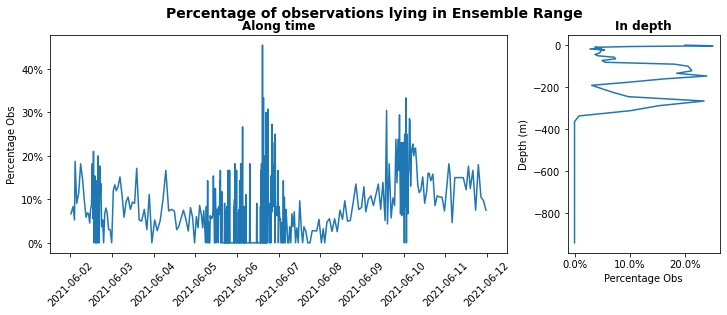

In [13]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter

fig = plt.figure(figsize=(12,4))
fig.suptitle("Percentage of observations lying in Ensemble Range", fontsize=14, fontweight='bold')

gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
ax1.plot(ds_glider.time.values, np.nanmean(perc_salt, axis=0) )
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.set_title('Along time', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage Obs')
plt.xticks(rotation=45)

ax2 = fig.add_subplot(gs[1])
ax2.plot( np.nanmean(perc_salt, axis=1), -ds_temp.deptht)
ax2.set_title('In depth', fontsize=12, fontweight='bold')
ax2.set_xlabel('Percentage Obs')
ax2.set_ylabel('Depth (m)')
ax2.xaxis.set_major_formatter(PercentFormatter(1))

plt.show()

#### Plot Rank Histogram

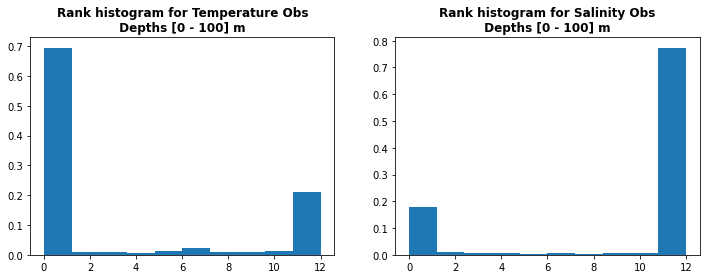

In [17]:
dmin = 0
dmax = 100

if dmin < ds_temp.deptht.min():
    nmin = 0
else:
    nmin = np.argwhere( ds_temp.deptht.values < dmin)[-1][0]
nmax = np.argwhere( ds_temp.deptht.values > dmax)[0][0]

# Put as array and extract NaNs
rank_temp_flat = rank_pos_temp[nmin:nmax,:].flatten()
rank_temp_flat = rank_temp_flat[~np.isnan(rank_temp_flat)]

rank_salt_flat = rank_pos_salt[nmin:nmax,:].flatten()
rank_salt_flat = rank_salt_flat[~np.isnan(rank_salt_flat)]


fig_rank = plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist( rank_temp_flat, weights=np.ones(len(rank_temp_flat)) / len(rank_temp_flat))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title(F'Rank histogram for Temperature Obs\n Depths [{dmin} - {dmax}] m ', fontsize=12, fontweight='bold')

plt.subplot(1,2,2)
plt.hist( rank_salt_flat, weights=np.ones(len(rank_salt_flat)) / len(rank_salt_flat))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title(F'Rank histogram for Salinity Obs\n Depths [{dmin} - {dmax}] m ', fontsize=12, fontweight='bold')

plt.show()

fig_rank.savefig(F"/home/jhernandez/Escritorio/WP4_T4.3/rank_histogram_ensemble-vs-glider_profiles_{dmin}-{dmax}m.png",
                 dpi=250, transparent=False, facecolor="w")

#### Check error fo each ensmeble Member

Each ensemble member is generated by using the day $t-n$ as initial state.

The member 0 is the "official forecast" and should be the most reliable. Theoretically, memeber n should have a initial state more different to the observations.

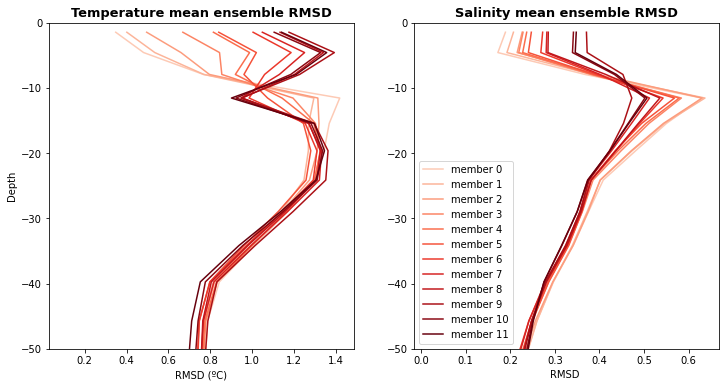

In [101]:
zmin=50

fig_rmsd_prof = plt.figure(figsize=(12,6))

colormap = 'Reds'#plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0, 1, 10))))

ax1 = plt.subplot(1,2,1)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0.2, 1, len(files_temp)))))
ax2 = plt.subplot(1,2,2)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0.2, 1, len(files_temp)))))

for i in range(len(files_temp)):
    ax1.plot(np.sqrt(np.nanmean(misfit_temp[i,:,:]**2, axis=1).T), -ds_temp.deptht.values, label=F"member {i}")
    ax2.plot(np.sqrt(np.nanmean(misfit_salt[i,:,:]**2, axis=1).T), -ds_salt.deptht.values, label=F"member {i}")
ax1.set_ylim((-zmin,0))
ax2.set_ylim((-zmin,0))
plt.legend()
ax1.set_title('Temperature mean ensemble RMSD', fontsize=13, fontweight='bold')
ax2.set_title('Salinity mean ensemble RMSD', fontsize=13, fontweight='bold')
ax1.set_ylabel('Depth')
ax1.set_xlabel('RMSD (ºC)')
ax2.set_xlabel('RMSD ')


#ax2.plot(-ds_temp.deptht.values*0, -ds_temp.deptht.values, 'k--', linewidth=0.6)
plt.show()

In [676]:
fig_rmsd_prof.savefig("/home/jhernandez/Escritorio/WP4_T4.3/rmsd_ensemble-vs-glider_profiles_0-{zmin}m.png",
                 dpi=250, transparent=False, facecolor="w")

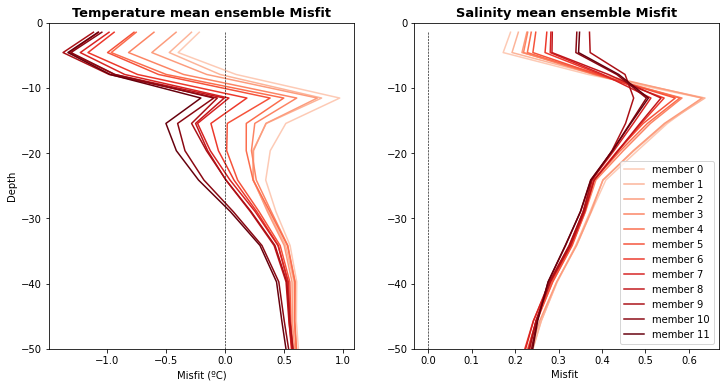

In [102]:
zmin=50

fig_rmsd_prof = plt.figure(figsize=(12,6))

colormap = 'Reds'#plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0, 1, 10))))

ax1 = plt.subplot(1,2,1)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0.2, 1, len(files_temp)))))
ax2 = plt.subplot(1,2,2)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Reds(np.linspace(0.2, 1, len(files_temp)))))

for i in range(len(files_temp)):
    ax1.plot(np.nanmean(misfit_temp[i,:,:], axis=1).T, -ds_temp.deptht.values, label=F"member {i}")
    ax2.plot(np.sqrt(np.nanmean(misfit_salt[i,:,:]**2, axis=1).T), -ds_temp.deptht.values, label=F"member {i}")
ax1.set_ylim((-zmin,0))
ax2.set_ylim((-zmin,0))
plt.legend()
ax1.set_title('Temperature mean ensemble Misfit', fontsize=13, fontweight='bold')
ax2.set_title('Salinity mean ensemble Misfit', fontsize=13, fontweight='bold')
ax1.set_ylabel('Depth')
ax1.set_xlabel('Misfit (ºC)')
ax2.set_xlabel('Misfit ')

ax1.plot(-ds_temp.deptht.values*0, -ds_temp.deptht.values, 'k--', linewidth=0.6)
ax2.plot(-ds_temp.deptht.values*0, -ds_temp.deptht.values, 'k--', linewidth=0.6)

plt.show()

In [684]:
fig_rmsd_prof.savefig(F"/home/jhernandez/Escritorio/WP4_T4.3/misfit_ensemble-vs-glider_profiles_0-{zmin}m.png",
                 dpi=250, transparent=False, facecolor="w")

In [75]:
import seaborn as sns

In [76]:
Temp_glider_interp.shape

(72, 484)

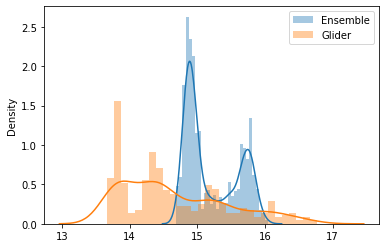

In [95]:
nz = 10

sns.distplot(Temp_ensemble_interp[:,nz,:], bins=30, label='Ensemble')
sns.distplot(Temp_glider_interp[nz,:], bins=30, label='Glider')
plt.legend()
plt.show()

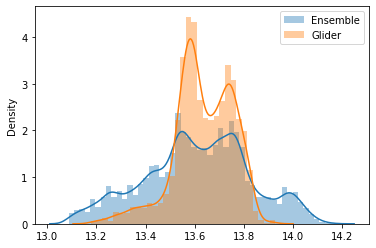

In [85]:
sns.distplot(Temp_ensemble_interp[:,20:,:], label='Ensemble')
sns.distplot(Temp_glider_interp[20:,:], label='Glider')
plt.legend()
plt.show()